# 0. Global Items

## 0.1 Imports and Constants

In [2]:
# Imports

# Personal functions
from circuits import *
from qubits import *

# Numbers and plotting
import numpy as np
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import collections

# Quantum tools
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeMelbourne
from ibm_quantum_widgets import *

# Constants
N = 100000 # Number of iterations

## 0.2 IBM Account

In [3]:
# Loading your IBM Quantum account(s)
mute = IBMQ.save_account('', overwrite=True)
provider = IBMQ.load_account()

## 0.3 IBM Computer

In [4]:
backend = FakeMelbourne()
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates
KWARGS = {"coupling_map": coupling_map, "basis_gates": basis_gates, "noise_model": noise_model, "shots": N}

## 0.4 Functions

### 0.4.1 Results

In [5]:
def find_success_rates(num_qubits, num_print, circuit, answer):
    """ Plots the results from Qiskit 
    
    Args:
        num_qubits: The number of qubits that will change
        num_print: The total number of qubits
        circuit: The circuit to be used
        answer: The function used to calculate success """
    
    # Preparation
    rates = {}
    format_string = "{0:0" + str(num_qubits) + "b}"
    print_string = "{0:0" + str(num_print) + "b}"
    print("Input: Expected Output, Actual Output, Number of Occurances (n = " + str(N) + ")")
    
    # For each input
    for input_num in range(pow(2,num_qubits)):

        # Making a list of the input qubit states
        qubits = []
        binary_num = [int(x) for x in list(format_string.format(input_num))]
        
        # Sorting out the expected output
        expected_output = answer(input_num)

        # Running Qiskit
        qc = circuit.get_quantum_circuit(get_qubits(input_num, 6))
        result = execute(qc, Aer.get_backend('qasm_simulator'), **KWARGS).result()

        # Storing results
        counts = result.get_counts(0)
        rates[format_string.format(input_num)] = counts.get(print_string.format(expected_output))

        # Printing results
        print(format_string.format(input_num),":",
              print_string.format(expected_output), 
              counts.most_frequent(), 
              counts.get(counts.most_frequent()))
        if (counts.most_frequent() != print_string.format(expected_output)):
            print("^ The most frequent result for",format_string.format(input_num),"was not the expected result.")
    
    return rates

def sort_results(results):
    """ Cleans and sorts results by Hamming weight """
    results_copy = results.copy()
    for k, v in results_copy.items():
        if v is None:
            results_copy[k] = 0
        else:
            results_copy[k] = results_copy[k]/N

    results_copy = dict(collections.OrderedDict(sorted(results_copy.items(), key=lambda x: (x[0].count("1"), x))))
    return results_copy

""" Success functions for different adders """

def in_place_with(input_num):
    return find_addition(list_to_num(to_binary(input_num, 6)))

def in_place_without(input_num):
    number = to_binary(find_addition(input_num), 6)
    number.insert(0,0)
    return list_to_num(number)



### 0.4.1 Plotting

In [6]:
def plot_results(results, title, num_occur, hamming):
    """ Plots the results from Qiskit 
    
    Args:
        results: The dictionary of results
        title: String for the title
        num_occur: Number of iterations
        hamming: Sort graph by Hamming weight or by occurances """
    
    for k, v in results.items():
        if v is None:
            results[k] = 0
        
    # Sorting results by Hamming weight
    if hamming == True:
        results = dict(collections.OrderedDict(sorted(results.items(), key=lambda x: (x[0].count("1"), x))))
    # Else sort by occurances
    else:
        results = dict(collections.OrderedDict(sorted(results.values())))
    
    # Plotting specifications
    plt.rcParams["figure.figsize"] = (20,5)
    
    fig, ax = plt.subplots()
    ax.grid('on', which='both', axis='y', color='lightgrey', linestyle='--', zorder=10)
    ax.set_axisbelow(True)
    
    plt.bar(range(len(results)), list(results.values()), align='center')

    plt.title(title)
    plt.xlabel("Input Qubits")
    plt.xticks(range(len(results)), list(results.keys()))
    plt.xticks(rotation = 90)
    plt.ylabel("Number of Successes (n = " + str(num_occur) + ")")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(num_occur))
    ax.set_ylim(0, num_occur/2)
    
    plt.show()

# 1. In Place Adders

## 1.1 In Place Adder With CCCNOTs

### 1.1.1 Circuit Representation

In [7]:
ip_with = circuit_builder(
    6,
[
    [0, [[2, 3, 6], 1], 0], 
    [1, [[2, 5], 1], 0], 
    [0, [[2, 5], 1], 1],
    [2, [[4], 1], 0], 
    [1, [[4], 1], 1], 
    [0, [[4], 1], 2], 
    
])


### 1.1.2 Success Rates for Each Input

In [8]:
# Dictionary for storing results
results_ip_with = find_success_rates(6, 6, ip_with, in_place_with)

Input: Expected Output, Actual Output, Number of Occurances (n = 100000)
000000 : 000000 000000 35200
000001 : 000001 000001 26743
000010 : 000010 000010 18991
000011 : 000011 000011 19181
000100 : 000100 000100 21795
000101 : 000101 000101 14051
000110 : 000110 000110 10272
000111 : 000111 000111 7526
001000 : 001001 001001 21443
001001 : 001000 001000 17522
001010 : 001011 001011 12109
001011 : 001010 001010 12823
001100 : 001101 001101 13715
001101 : 001100 001100 14201
001110 : 001111 001011 7162
^ The most frequent result for 001110 was not the expected result.
001111 : 001110 001110 9944
010000 : 010010 010010 18676
010001 : 010011 010011 23562
010010 : 010001 010001 13157
010011 : 010000 010000 10969
010100 : 010110 010110 12087
010101 : 010111 010111 9928
010110 : 010101 010101 7456
010111 : 010100 010100 8144
011000 : 011011 011011 13954
011001 : 011010 011010 10466
011010 : 011000 011000 14002
011011 : 011001 011001 9435
011100 : 011111 011111 12174
011101 : 011110 011010 564

### 1.1.3 Graph Obtained

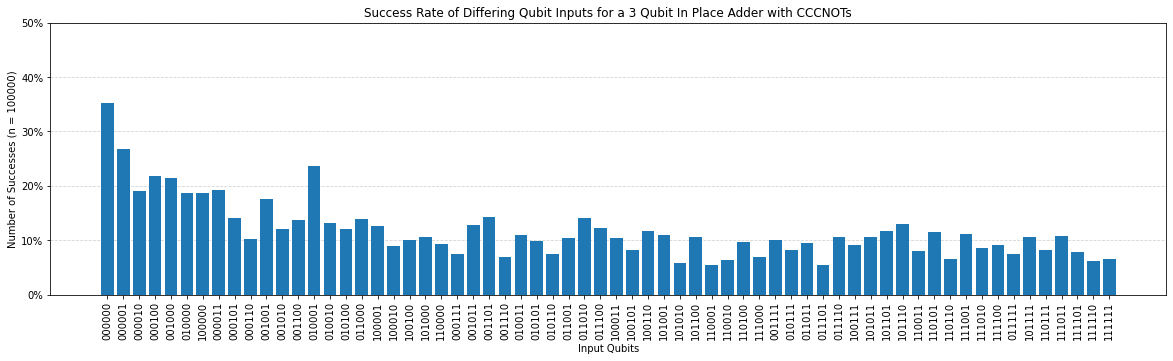

In [9]:
title = "Success Rate of Differing Qubit Inputs for a 3 Qubit In Place Adder with CCCNOTs"

plot_results(results_ip_with, title, N, True)

## 1.2 In Place Adder Without CCCNOTs

### 1.2.1 Circuit Representation

In [10]:
ip_without = circuit_builder(
    7,
[
    [1, [[1, 2], 6], 0], 
    [0, [[6, 7], 1], 0], 
    [1, [[1, 2], 6], 0], 
    [1, [[2, 5], 1], 1], 
    [0, [[2, 5], 1], 2], 
    [2, [[4], 1], 1],
    [1, [[4], 1], 2], 
    [0, [[4], 1], 3], 
    
     
])

### 1.2.2 Success Rates for Each Input

In [11]:
results_ip_without = find_success_rates(6, 7, ip_without, in_place_without)

Input: Expected Output, Actual Output, Number of Occurances (n = 100000)
000000 : 0000000 0000000 13744
000001 : 0000001 0000001 13156
000010 : 0000010 0000010 12650
000011 : 0000011 0000011 9744
000100 : 0000100 0000100 15407
000101 : 0000101 0000101 9539
000110 : 0000110 0000100 5773
^ The most frequent result for 000110 was not the expected result.
000111 : 0000111 0000111 8161
001000 : 0001001 0001001 17197
001001 : 0001000 0001000 13847
001010 : 0001011 0001011 9970
001011 : 0001010 0001010 9440
001100 : 0001101 0001101 9766
001101 : 0001100 0001100 8441
001110 : 0001111 0001111 5881
001111 : 0001110 0001110 10609
010000 : 0010010 0010010 14152
010001 : 0010011 0010011 11227
010010 : 0010001 0010001 9359
010011 : 0010000 0010000 12222
010100 : 0010110 0010110 7848
010101 : 0010111 0010111 9542
010110 : 0010101 0010101 8075
010111 : 0010100 0010100 10306
011000 : 0011011 0011011 8430
011001 : 0011010 0011010 10299
011010 : 0011000 0011000 16249
011011 : 0011001 0011001 7352
011100 

### 1.1.3 Graph Obtained

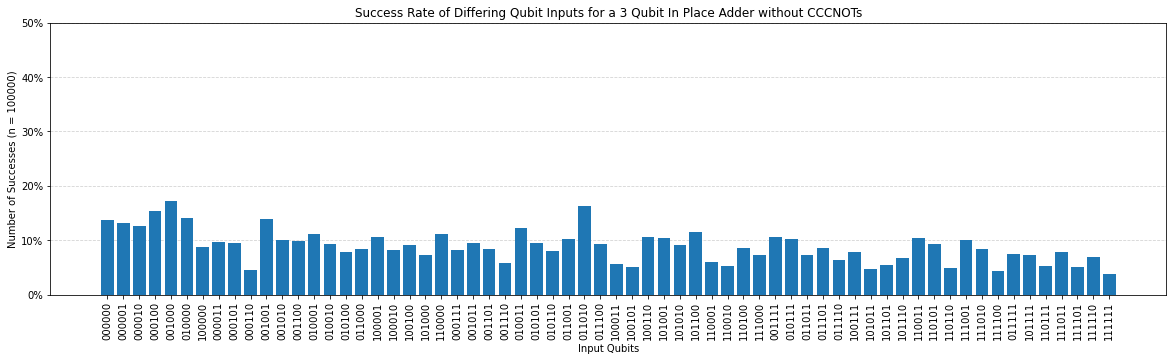

In [12]:
title = "Success Rate of Differing Qubit Inputs for a 3 Qubit In Place Adder without CCCNOTs"

plot_results(results_ip_without, title, N, True)

## 1.3 Comparisons

### 1.3.1 Graph

Text(0.5, 1.0, 'Comparison of Success Rate of Two Different 3 Qubit In Place Adders')

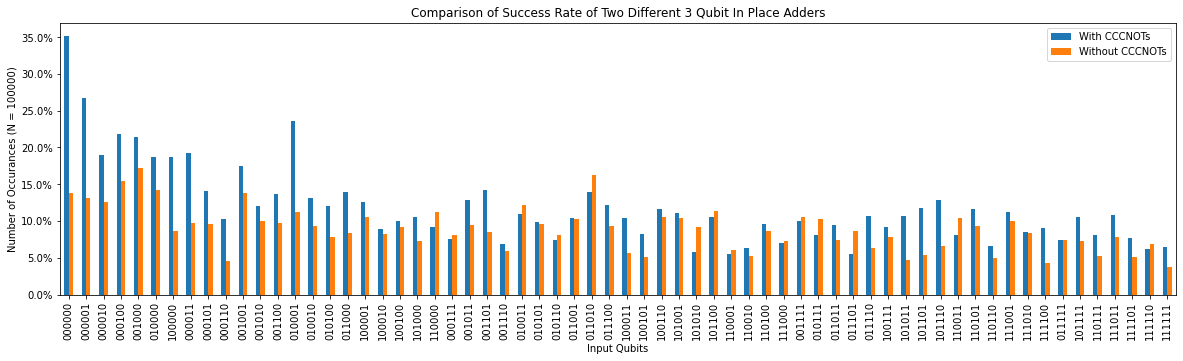

In [13]:
sorted_ip_with = sort_results(results_ip_with)
sorted_ip_without = sort_results(results_ip_without)

ip = pd.DataFrame(
    {'Input Qubits': sorted_ip_with.keys(),
     'With CCCNOTs': sorted_ip_with.values(),
     'Without CCCNOTs': sorted_ip_without.values()
    })

ax = ip.plot(x="Input Qubits", y=["With CCCNOTs", "Without CCCNOTs"], kind="bar")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_ylabel("Number of Occurances (N = " + str(N) + ")")
ax.set_title("Comparison of Success Rate of Two Different 3 Qubit In Place Adders")


### 1.3.2 Average Percentages

In [14]:
print("Average success percent for in place adder with CCCNOTs: {0:0.1f}%".format(100*sum(sorted_ip_with.values())/len(sorted_ip_with)))
print("Average success percent for in place adder without CCCNOTs: {0:0.1f}%".format(100*sum(sorted_ip_without.values())/len(sorted_ip_without)))

Average success percent for in place adder with CCCNOTs: 11.8%
Average success percent for in place adder without CCCNOTs: 8.9%


# 2. Out of Place Adders

## 2.1 Out of Place Adder With CCCNOTs

### 2.1.1 Circuit Representation

In [15]:
op_with = circuit_builder(
    9,
[
    [0, [[7], 1], 2],
    [1, [[7], 1], 1],
    [2, [[7], 1], 0],
    [0, [[4], 1], 5],
    [1, [[4], 1], 4],
    [2, [[4], 1], 3],
    [0, [[5, 8], 1], 1],
    [1, [[5, 8], 1], 0],
    [0, [[5, 6, 9], 1], 0],
    [0, [[6, 8, 9], 1], 0],
])

### 2.1.2 Success Rates for Each Input

In [16]:
print("Input: Expected Output, Actual Output, Number of Occurances (n = " + str(N) + ")")

results_op_with = {}

for i in range(64):
    # Adding ancilla
    input_num = i
    input_num = to_binary(input_num, 6)
    input_num.extend([0, 0, 0])
    input_num = list_to_num(input_num)
    
    # Running Qiskit
    qc = op_with.get_quantum_circuit(get_qubits(input_num, 9))
    result = execute(qc, Aer.get_backend('qasm_simulator'),
                     coupling_map=coupling_map,
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=N).result()
    
    # Sorting out the final input and outputs
    expected_output = to_binary(find_addition(i), 6)[3:6]
    final_num = to_binary(i, 6)
    final_num.extend(expected_output)
    expected_output = list_to_num(final_num)
    
    # Storing results
    counts = result.get_counts(0)
    results_op_with['{0:06b}'.format(i)] = counts.get('{0:09b}'.format(expected_output))
    
    try:
        print('{0:06b}'.format(i), ":",
              '{0:09b}'.format(expected_output),
              counts.most_frequent(), 
              counts.get(counts.most_frequent()))
        if counts.most_frequent() != '{0:09b}'.format(expected_output):
            print("^ The most frequent result for",'{0:06b}'.format(i),"was not the expected result.")
    except:
         print('{0:06b}'.format(i), ":",
              '{0:09b}'.format(expected_output))
    

Input: Expected Output, Actual Output, Number of Occurances (n = 100000)
000000 : 000000000 000000000 11766
000001 : 000001001 000001001 9470
000010 : 000010010 000010010 4822
000011 : 000011011 000011011 5354
000100 : 000100100 000100100 5684
000101 : 000101101 000001100 2721
^ The most frequent result for 000101 was not the expected result.
000110 : 000110110 000110110 6509
000111 : 000111111 000111111 2450
001000 : 001000001 001000001 9314
001001 : 001001000 001001000 10678
001010 : 001010011 001010011 4349
001011 : 001011010 001011010 5459
001100 : 001100101 001100101 3966
001101 : 001101100 001001100 5152
^ The most frequent result for 001101 was not the expected result.
001110 : 001110111 001010111 2048
^ The most frequent result for 001110 was not the expected result.
001111 : 001111110 001011110 2810
^ The most frequent result for 001111 was not the expected result.
010000 : 010000010 010000010 6540
010001 : 010001011 010001011 6455
010010 : 010010001 010010000 4852
^ The most 

### 2.1.3 Graph Obtained

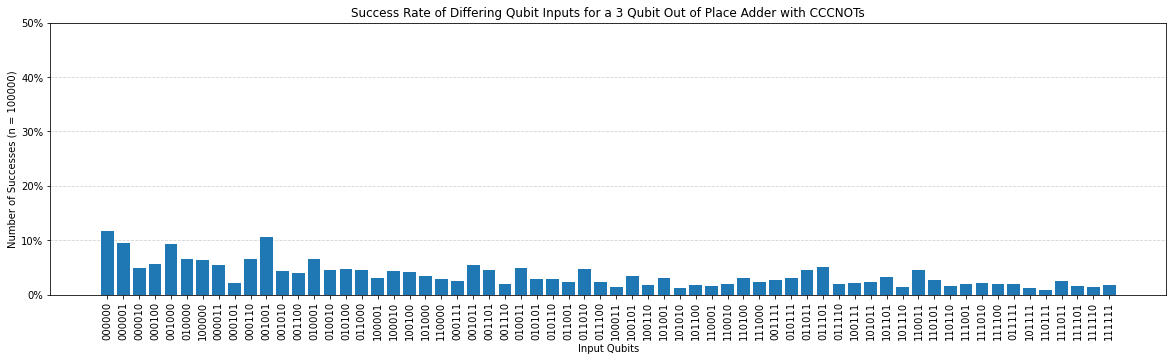

In [17]:
title = "Success Rate of Differing Qubit Inputs for a 3 Qubit Out of Place Adder with CCCNOTs"

plot_results(results_op_with, title, N, True)

## 2.2 Out of Place Adder Without CCCNOTs

### 2.2.1 Circuit Representation

In [18]:
op_without = circuit_builder(
    9,
[
    [1, [[5, 8], 1], 0],
    [0, [[2, 5], 1], 4],
    [0, [[2, 8], 1], 1],
    [0, [[5, 8], 1], 1],
    [0, [[7], 1], 2],
    [1, [[7], 1], 1],
    [2, [[7], 1], 0],
    [0, [[4], 1], 5],
    [1, [[4], 1], 4],
    [2, [[4], 1], 3],

])

### 2.2.2 Success Rates for Each Input

In [19]:
results_op_without = {}

for i in range(64):
    # Adding ancilla
    input_num = i
    input_num = to_binary(input_num, 6)
    input_num.extend([0, 0, 0])
    input_num = list_to_num(input_num)
    
    # Running Qiskit
    qc = op_without.get_quantum_circuit(get_qubits(input_num, 9))
    result = execute(qc, Aer.get_backend('qasm_simulator'),
                     coupling_map=coupling_map,
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=N).result()
    
    # Sorting out the final input and outputs
    expected_output = to_binary(find_addition(i), 6)[3:6]
    final_num = to_binary(i, 6)
    final_num.extend(expected_output)
    expected_output = list_to_num(final_num)
    
    # Storing results
    counts = result.get_counts(0)
    results_op_without['{0:06b}'.format(i)] = counts.get('{0:09b}'.format(expected_output))
    
    try:
        print('{0:06b}'.format(i), ":",
              '{0:09b}'.format(expected_output),
              counts.most_frequent(), 
              counts.get(counts.most_frequent()))
        if counts.most_frequent() != '{0:09b}'.format(expected_output):
            print("^ The most frequent result for",'{0:06b}'.format(i),"was not the expected result.")
    except:
         print('{0:06b}'.format(i), ":",
              '{0:09b}'.format(expected_output))
    

000000 : 000000000 000000000 18622
000001 : 000001001 000001001 15390
000010 : 000010010 000010010 9742
000011 : 000011011 000011011 7516
000100 : 000100100 000100100 13239
000101 : 000101101 000101101 8979
000110 : 000110110 000110110 8168
000111 : 000111111 000111111 9318
001000 : 001000001 001000001 13001
001001 : 001001000 001001000 13591
001010 : 001010011 001010011 9773
001011 : 001011010 001011010 10066
001100 : 001100101 001100101 9981
001101 : 001101100 001101100 12642
001110 : 001110111 001110111 7064
001111 : 001111110 001111110 5979
010000 : 010000010 010000010 9554
010001 : 010001011 010001011 11797
010010 : 010010001 010010001 10065
010011 : 010011000 010011000 6103
010100 : 010100110 010100110 9274
010101 : 010101111 010101111 6522
010110 : 010110101 010110101 6178
010111 : 010111100 010111100 4748
011000 : 011000011 011000011 10181
011001 : 011001010 011001010 6963
011010 : 011010000 011010000 7104
011011 : 011011001 011011001 5121
011100 : 011100111 011100111 7878
0111

### 2.2.3 Graph Obtained

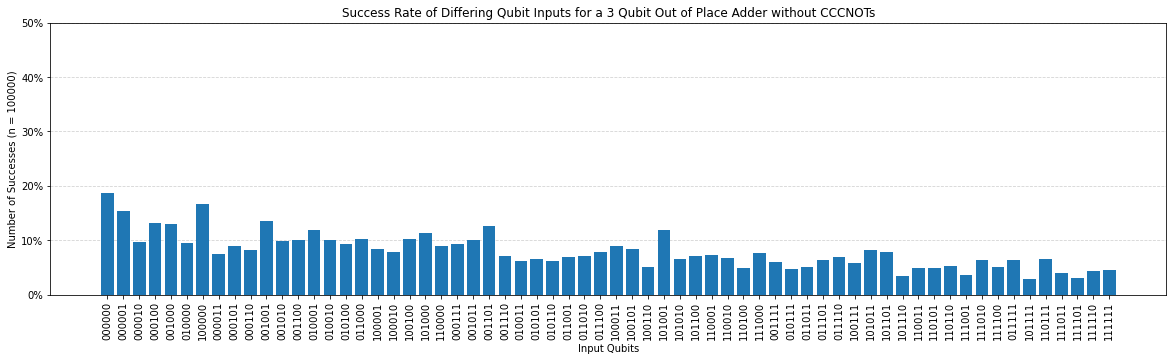

In [20]:
title = "Success Rate of Differing Qubit Inputs for a 3 Qubit Out of Place Adder without CCCNOTs"

plot_results(results_op_without, title, N, True)

## 2.3 Comparisons

### 2.3.1 Graph

Text(0.5, 1.0, 'Comparison of Success Rate of Two Different 3 Qubit In Place Adders')

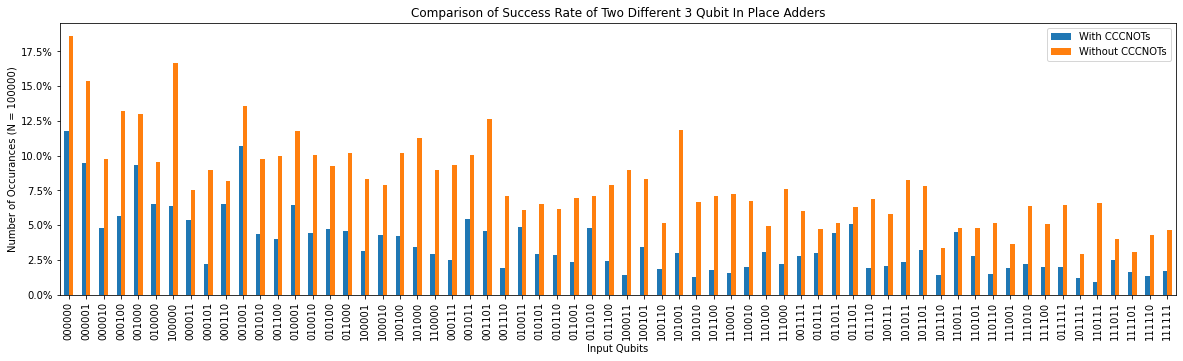

In [21]:
sorted_op_with = sort_results(results_op_with)
sorted_op_without = sort_results(results_op_without)

op = pd.DataFrame(
    {'Input Qubits': sorted_op_with.keys(),
     'With CCCNOTs': sorted_op_with.values(),
     'Without CCCNOTs': sorted_op_without.values()
    })

ax = op.plot(x="Input Qubits", y=["With CCCNOTs", "Without CCCNOTs"], kind="bar")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_ylabel("Number of Occurances (N = " + str(N) + ")")
ax.set_title("Comparison of Success Rate of Two Different 3 Qubit In Place Adders")



### 2.3.2 Average Percentages

In [22]:
print("Average success percent for out of place adder with CCCNOTs: {0:0.1f}%".format(100*sum(sorted_op_with.values())/len(sorted_op_with)))
print("Average success percent for out of place adder without CCCNOTs: {0:0.1f}%".format(100*sum(sorted_op_without.values())/len(sorted_op_without)))

Average success percent for out of place adder with CCCNOTs: 3.6%
Average success percent for out of place adder without CCCNOTs: 8.0%


# 3. Saving Data

In [24]:
import json

with open('sorted_ip_with.json', 'w') as fp:
    json.dump(sorted_ip_with, fp)

with open('sorted_ip_without.json', 'w') as fp:
    json.dump(sorted_ip_without, fp)

with open('sorted_op_with.json', 'w') as fp:
    json.dump(sorted_op_with, fp)

with open('sorted_op_without.json', 'w') as fp:
    json.dump(sorted_op_without, fp)